In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts/ConceptBottleneck/')
sys.path.append('/usr0/home/naveenr/projects/spurious_concepts')

In [3]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
import json
import matplotlib.image as mpimg
from collections import Counter
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from itertools import chain


/usr0/home/naveenr/miniconda3/envs/concepts_spurious/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

# Plots for ICML

## Synthetic Dataset

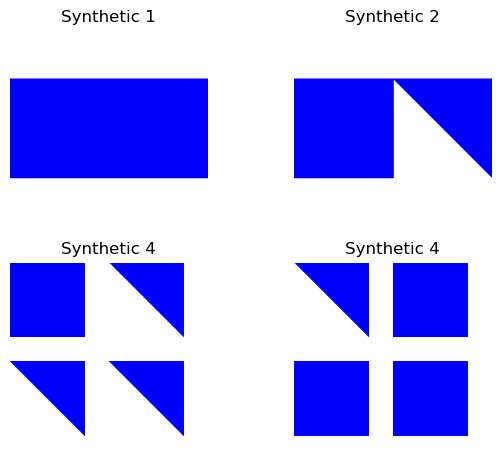

In [5]:
num_objects_list = [1, 2, 4, 4]

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2)

# Loop through the images and display them in the subplots
for i, num_objects in enumerate(num_objects_list):
    img_num = i+1 

    file_loc = "../../results/synthetic/objects={}_noisy=False_wd=0.0004_model=small3_optimizer=sgd_seed=42/{}.png".format(num_objects,img_num)
    img = Image.open(file_loc)
    
    # Determine the subplot position
    row = i // 2
    col = i % 2
    
    # Display the image in the appropriate subplot
    axs[row, col].imshow(img)
    axs[row, col].set_title('Synthetic {}'.format(num_objects))
    axs[row, col].axis('off')

# Remove the empty subplot
if len(num_objects_list) < 4:
    fig.delaxes(axs[1, 1])

# Adjust layout
plt.tight_layout()

plt.savefig("../../results/figures/example_dataset.pdf",dpi=300, bbox_inches='tight')

# Show the grid of images
plt.show()

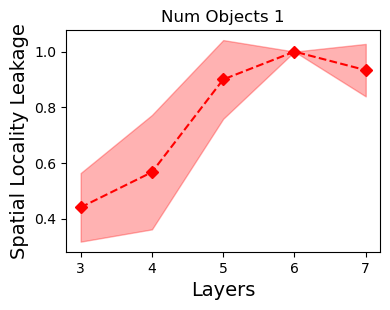

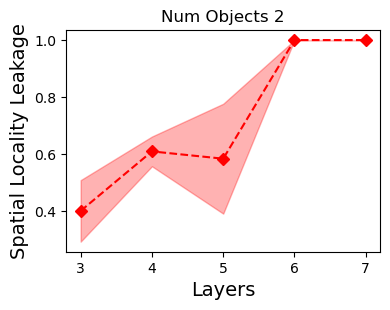

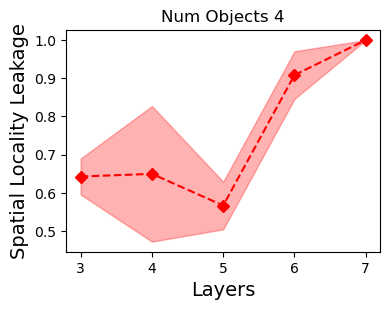

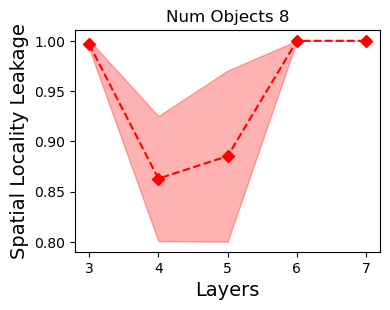

In [6]:

for num_objects in [1,2,4,8]:
    activations_by_size = [] 
    for num_layers in range(3,8):
        activations_by_size.append([])
        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            activations_by_size[-1].append(np.mean(results['adversarial_activations']))

    activations_by_size = np.array(activations_by_size)
    mean_vals = np.mean(activations_by_size,axis=1)
    std_vals = np.std(activations_by_size,axis=1)

    x_vals = list(range(3,8))

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='red')
    plt.plot(x_vals, mean_vals, 'rD--')


    # Add labels, legend, and title
    plt.xlabel('Layers',fontsize=14)
    plt.ylabel('Spatial Locality Leakage',fontsize=14)

    plt.tight_layout()

    plt.title("Num Objects {}".format(num_objects))
    plt.savefig("../../results/figures/cnn_activation_{}.pdf".format(num_objects),dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

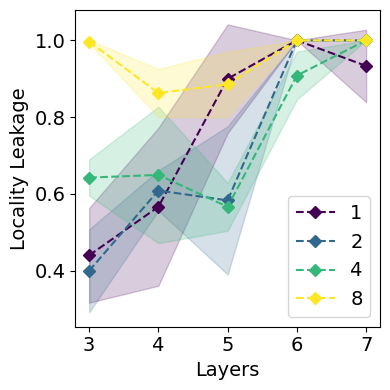

In [17]:
plt.figure(figsize=(4,4))
color_palette = plt.cm.viridis(np.linspace(0, 1, 4))
for i,num_objects in enumerate([1,2,4,8]):
    activations_by_size = [] 
    for num_layers in range(3,8):
        activations_by_size.append([])
        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            activations_by_size[-1].append(np.mean(results['adversarial_activations']))

    activations_by_size = np.array(activations_by_size)
    mean_vals = np.mean(activations_by_size,axis=1)
    std_vals = np.std(activations_by_size,axis=1)

    x_vals = list(range(3,8))

    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2,  color=color_palette[i])
    plt.plot(x_vals, mean_vals, 'D--',color=color_palette[i],label=str(num_objects))


    # Add labels, legend, and title
plt.xlabel('Layers',fontsize=14)
plt.ylabel('Locality Leakage',fontsize=14)
plt.yticks([0.4,0.6,0.8,1.0],fontsize=14)
plt.legend(fontsize=14)
plt.xticks([3,4,5,6,7],fontsize=14)

plt.tight_layout()

plt.savefig("../../results/figures/cnn_activation_all_objects.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
parameters_by_size = [] 

for num_layers in range(3,8):
    joint_model = get_synthetic_model("synthetic_object/synthetic_1",{'dataset': "synthetic_object/synthetic_1",'encoder_model': "small{}".format(num_layers), 'seed': 42, 'epochs': 50, 'num_attributes': 2})
    parameters_by_size.append(sum(p.numel() for p in joint_model.parameters()))

x_vals = list(range(3,8))

plt.figure(figsize=(4,3))

plt.plot(x_vals, parameters_by_size, 'rD--')


# Add labels, legend, and title
plt.xlabel('Layers',fontsize=14)
plt.ylabel('Parameters',fontsize=14)

plt.tight_layout()

plt.savefig("../../results/figures/cnn_parameters.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

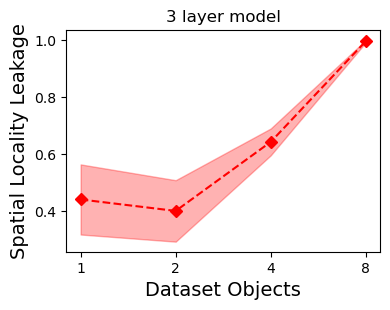

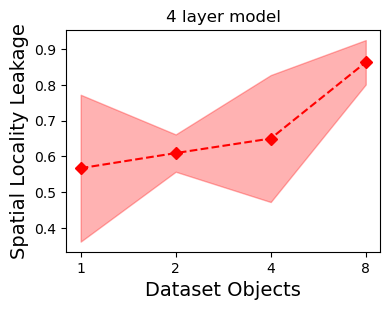

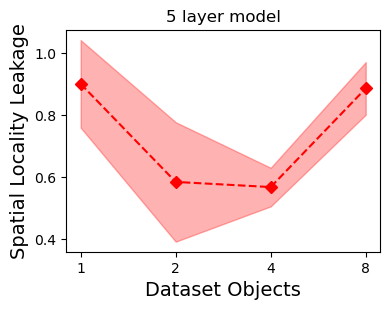

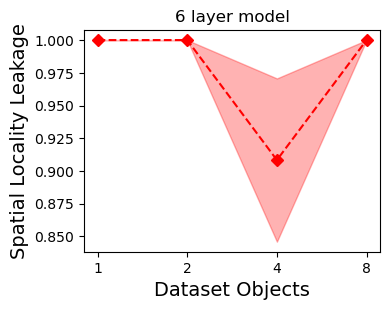

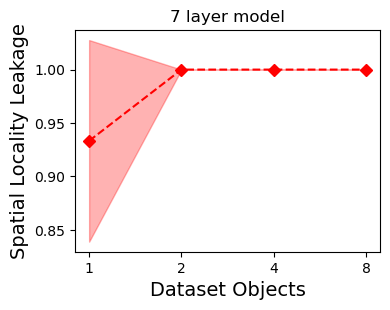

In [18]:
for num_layers in range(3,8):

    activations_by_size = [] 
    for num_objects in [1,2,4,8]:
        activations_by_size.append([])
        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            activations_by_size[-1].append(np.mean(results['adversarial_activations']))

    activations_by_size = np.array(activations_by_size)
    mean_vals = np.mean(activations_by_size,axis=1)
    std_vals = np.std(activations_by_size,axis=1)

    x_vals = list(range(0,4))

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='red')
    plt.plot(x_vals, mean_vals, 'rD--')


    # Add labels, legend, and title
    plt.xlabel('Dataset Objects',fontsize=14)
    plt.ylabel('Spatial Locality Leakage',fontsize=14)
    plt.xticks(x_vals,[1,2,4,8])

    plt.tight_layout()

    plt.title("{} layer model".format(num_layers))
    plt.savefig("../../results/figures/cnn_activation_nobjects_{}.pdf".format(num_layers),dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

0.7 1 42
0.9999999996545808 1 43
1.0 1 44
0.4 2 42
0.8500000000000039 2 43
0.5 2 44
0.4999994933605194 4 42
0.6500020115558613 4 43
0.55000000894076 4 44
0.8595542154328313 8 42
0.7964809567191571 8 43
1.0 8 44


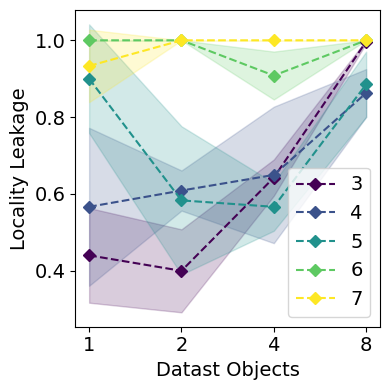

In [27]:
plt.figure(figsize=(4,4))
color_palette = plt.cm.viridis(np.linspace(0, 1, 5))

for i,num_layers in enumerate(range(3,8)):

    activations_by_size = [] 
    for num_objects in [1,2,4,8]:
        activations_by_size.append([])
        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            if num_layers == 5:
                print(np.mean(results['adversarial_activations']),num_objects,seed)
            activations_by_size[-1].append(np.mean(results['adversarial_activations']))

    activations_by_size = np.array(activations_by_size)
    mean_vals = np.mean(activations_by_size,axis=1)
    std_vals = np.std(activations_by_size,axis=1)

    x_vals = list(range(0,4))

    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.2,  color=color_palette[i])
    plt.plot(x_vals, mean_vals, 'D--',color=color_palette[i],label=str(num_layers))


    # Add labels, legend, and title
plt.xlabel('Datast Objects',fontsize=14)
plt.ylabel('Locality Leakage',fontsize=14)
plt.yticks([0.4,0.6,0.8,1.0],fontsize=14)
plt.legend(fontsize=14)
plt.xticks(x_vals,[1,2,4,8],fontsize=14)

plt.tight_layout()

plt.savefig("../../results/figures/cnn_activation_all_layers.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

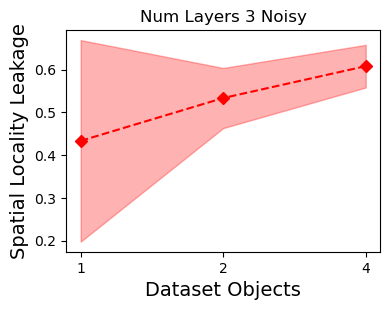

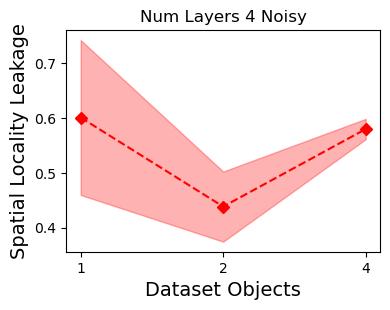

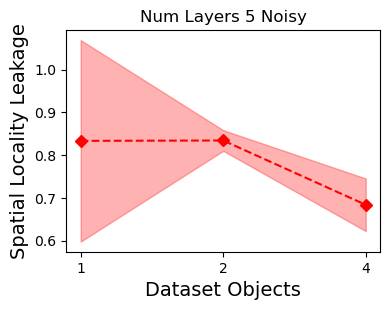

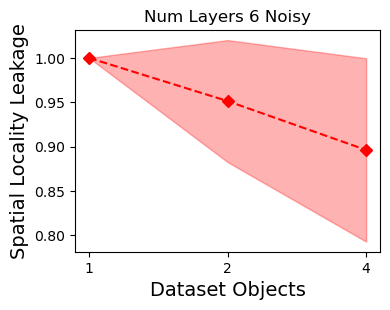

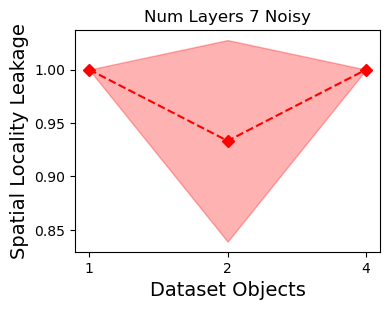

In [15]:
for num_layers in range(3,8):
    activations_by_size = [] 
    for num_objects in [1,2,4]:
        activations_by_size.append([])
        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}_noisy'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            activations_by_size[-1].append(np.mean(results['adversarial_activations']))

    activations_by_size = np.array(activations_by_size)
    mean_vals = np.mean(activations_by_size,axis=1)
    std_vals = np.std(activations_by_size,axis=1)

    x_vals = list(range(0,3))

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='red')
    plt.plot(x_vals, mean_vals, 'rD--')


    # Add labels, legend, and title
    plt.xlabel('Dataset Objects',fontsize=14)
    plt.ylabel('Spatial Locality Leakage',fontsize=14)
    plt.xticks(x_vals,[1,2,4])

    plt.tight_layout()

    plt.title("Num Layers {} Noisy".format(num_layers))
    plt.savefig("../../results/figures/cnn_activation_nobjects_{}.pdf".format(num_layers),dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

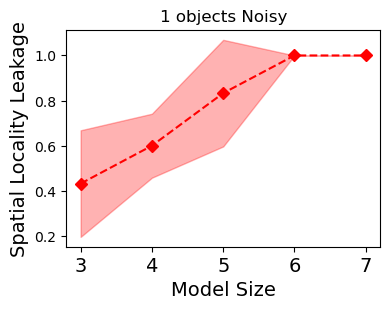

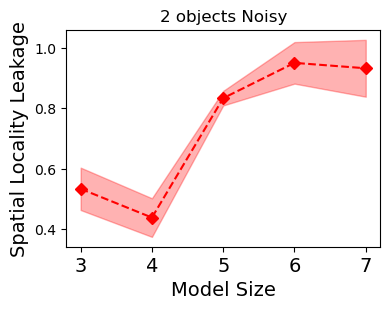

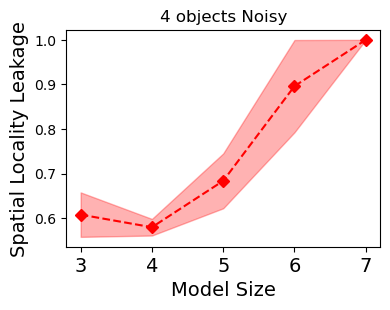

In [17]:
for num_objects in [1,2,4]:
    activations_by_size = [] 
    for num_layers in range(3,8):
        activations_by_size.append([])
        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}_noisy'.format(num_objects),'num_attributes': 2*num_objects,'seed': seed, 'encoder_model': 'small{}'.format(num_layers), 'epochs': 50, 'debugging': False})
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            activations_by_size[-1].append(np.mean(results['adversarial_activations']))

    activations_by_size = np.array(activations_by_size)
    mean_vals = np.mean(activations_by_size,axis=1)
    std_vals = np.std(activations_by_size,axis=1)

    x_vals = list(range(3,8))

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='red')
    plt.plot(x_vals, mean_vals, 'rD--')


    # Add labels, legend, and title
    plt.xlabel('Model Size',fontsize=14)
    plt.ylabel('Spatial Locality Leakage',fontsize=14)
    plt.xticks(x_vals,fontsize=14)

    plt.tight_layout()

    plt.title("{} objects Noisy".format(num_objects))
    plt.savefig("../../results/figures/cnn_activation_nobjects_noisy_{}.pdf".format(num_objects),dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

### Impact of Regularization

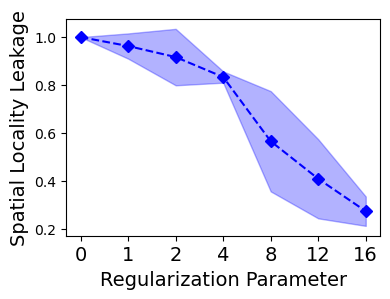

In [26]:
all_json = [json.load(open("../../results/synthetic/l2_norm/results_{}.json".format(seed))) for seed in [42,43,44]]
all_activation = [i['activation_values'] for i in all_json]
lamb_vals = all_json[0]['lambda']
all_activation = np.array(all_activation)
all_activation_mean = np.mean(all_activation,axis=0)
all_activation_std = np.std(all_activation,axis=0)

x_vals = list(range(len(lamb_vals)))

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, all_activation_mean - all_activation_std, all_activation_mean + all_activation_std, alpha=0.3,  color='blue')
plt.plot(x_vals, all_activation_mean, 'bD--')


# Add labels, legend, and title
plt.xlabel('Regularization Parameter',fontsize=14)
plt.ylabel('Spatial Locality Leakage',fontsize=14)
plt.xticks(x_vals,lamb_vals,fontsize=14)

plt.tight_layout()

plt.savefig("../../results/figures/regularization_sll.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

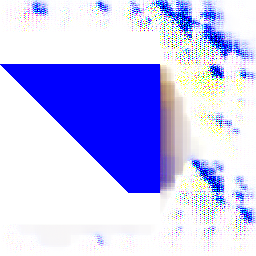

In [33]:
file_loc = "../../results/synthetic/l2_norm/example_4_42.png"
img = Image.open(file_loc)
img

array([1.        , 0.96275762, 0.9166751 , 0.83333339, 0.56513517,
       0.40842333, 0.27316601])

### Impact of Training Epochs

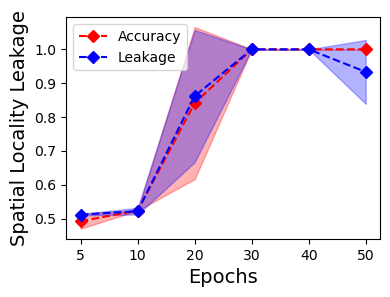

In [14]:
activations_by_size = [] 
accuracy_by_size = []
for epochs in [5,10,20,30,40,50]:
    activations_by_size.append([])
    accuracy_by_size.append([])
    for seed in [42,43,44]:
        result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_1','num_attributes': 2,'seed': seed, 'encoder_model': 'small7', 'epochs': epochs, 'debugging': False})
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        activations_by_size[-1].append(np.mean(results['adversarial_activations']))
        accuracy_by_size[-1].append(results['test_accuracy'])

activations_by_size = np.array(activations_by_size)
mean_vals = np.mean(activations_by_size,axis=1)
std_vals = np.std(activations_by_size,axis=1)

accuracy_by_size = np.array(accuracy_by_size)
mean_accuracy = np.mean(accuracy_by_size,axis=1)
std_accuracy = np.std(accuracy_by_size,axis=1)


x_vals = list(range(0,6))

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3,  color='red')
plt.plot(x_vals, mean_accuracy, 'rD--',label='Accuracy')


plt.fill_between(x_vals, mean_vals - std_vals, mean_vals + std_vals, alpha=0.3,  color='blue')
plt.plot(x_vals, mean_vals, 'bD--',label='Leakage')



# Add labels, legend, and title
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('Spatial Locality Leakage',fontsize=14)
plt.xticks(x_vals,[5,10,20,30,40,50])

plt.legend()

plt.tight_layout()

plt.savefig("../../results/figures/cnn_activation_epochs.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Impact of Model Size

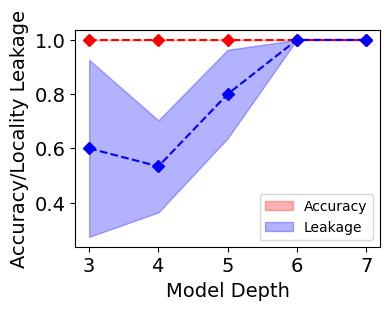

In [30]:
seeds = [42,43,44]
num_layers = 1
accuracy_values = []
leakage_values = []
for depth in [3,4,5,6,7]:
    accuracy_values.append([])
    leakage_values.append([])

    for seed in seeds:
        d = {'dataset': 'synthetic_object/synthetic_{}'.format(1),'num_attributes': 2,'seed': seed, 'encoder_model': 'equal_parameter{}'.format(depth) }
        if depth == 7:
            d['lr'] = 0.1
        result_name = get_name_matching_parameters(d)
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))

        accuracy_values[-1].append(results['test_accuracy'])
        leakage_values[-1].append(np.mean(results['adversarial_activations']))

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [3,4,5,6,7]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, label="Accuracy", color='red')
plt.plot(x_vals, mean_accuracy, 'rD--')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, label="Leakage", color='blue')
plt.plot(x_vals, mean_leakage, 'bD--')

# Add labels, legend, and title
plt.xlabel('Model Depth',fontsize=14)
plt.ylabel('Accuracy/Locality Leakage',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right') 
plt.tight_layout()

plt.savefig("../../results/figures/cnn_parameters_fixed.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

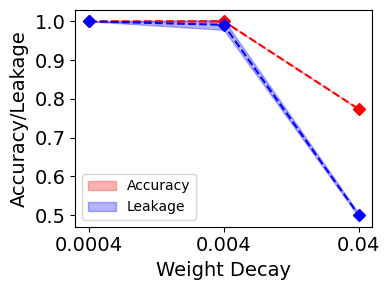

In [15]:
seeds = [42,43,44]
num_layers = 1
accuracy_values = []
leakage_values = []
for weight_decay in [0.04,0.004,0.0004][::-1]:
    accuracy_values.append([])
    leakage_values.append([])

    for seed in seeds:
        result_name = get_name_matching_parameters({'dataset': 'synthetic_object/synthetic_{}'.format(2),'num_attributes': 4,'seed': seed, 'encoder_model': 'small7','weight_decay': weight_decay })
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))

        accuracy_values[-1].append(results['test_accuracy'])
        leakage_values[-1].append(np.mean(results['adversarial_activations']))

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [1,2,3]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, label="Accuracy", color='red')
plt.plot(x_vals, mean_accuracy, 'rD--')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, label="Leakage", color='blue')
plt.plot(x_vals, mean_leakage, 'bD--')

plt.xticks(x_vals,[0.04,0.004,0.0004][::-1],fontsize=14)
plt.yticks(fontsize=14)

# Add labels, legend, and title
plt.xlabel('Weight Decay',fontsize=14)
plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.legend() 
plt.tight_layout()

plt.savefig("../../results/figures/cnn_weight_decay.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Impact of Pruning

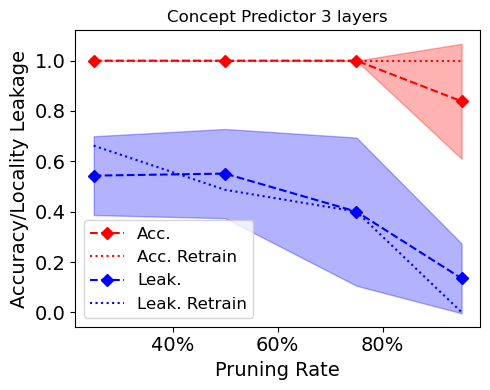

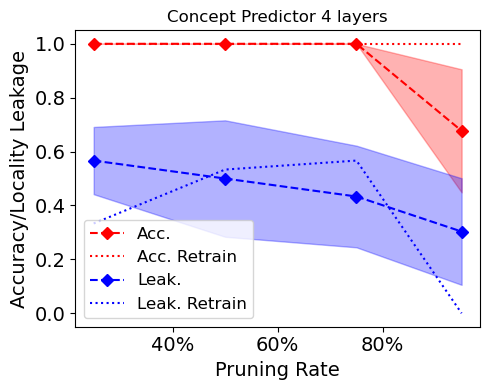

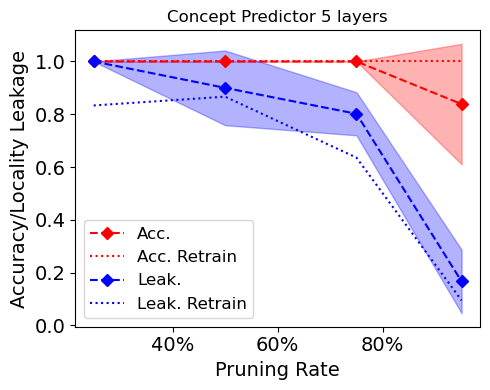

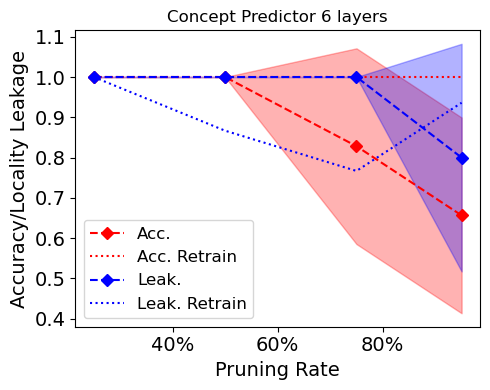

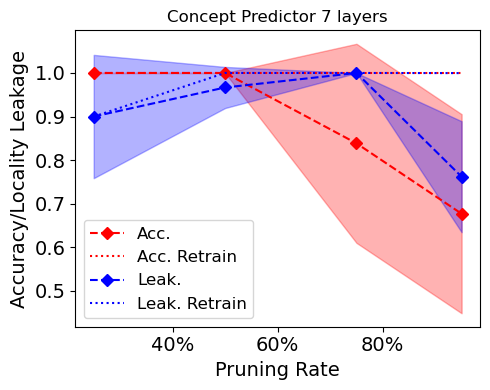

In [59]:
seeds = [42,43,44]
num_layers = 1

for encoder_model in ['small3','small4','small5','small6','small7']:
    accuracy_values = []
    leakage_values = []

    accuracy_values_retrain = []
    leakage_values_retrain = []


    for pruning_rate in [0.25,0.5,0.75,0.95]:
        accuracy_values.append([])
        leakage_values.append([])

        accuracy_values_retrain.append([])
        leakage_values_retrain.append([])

        for seed in seeds:
            for retrain_epochs in [0,5]:
                # TODO: Fix this, double parameters
                result_name = get_name_matching_parameters({'dataset_name': 'synthetic_object/synthetic_1', 'encoder_model': encoder_model,'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/pruning")
                result_name = result_name[0]
                results_loc = '../../results/pruning/{}.json'.format(result_name,seed)
                results = json.load(open(results_loc,"r"))

                if retrain_epochs == 0:
                    accuracy_values[-1].append(results['test_accuracy'])
                    leakage_values[-1].append(np.mean(results['adversarial_activations']))
                else:
                    accuracy_values_retrain[-1].append(results['test_accuracy'])
                    leakage_values_retrain[-1].append(np.mean(results['adversarial_activations']))


    accuracy_values = np.array(accuracy_values).T
    leakage_values = np.array(leakage_values).T
    accuracy_values_retrain = np.array(accuracy_values_retrain).T
    leakage_values_retrain = np.array(leakage_values_retrain).T

    mean_accuracy = np.mean(accuracy_values,axis=0)
    std_accuracy = np.std(accuracy_values,axis=0)
    mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
    std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

    mean_leakage = np.mean(leakage_values,axis=0)
    std_leakage = np.std(leakage_values,axis=0)
    mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
    std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

    x_vals = [0.25,0.5,0.75,0.95]

    plt.figure(figsize=(5,4))

    plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
    plt.plot(x_vals, mean_accuracy, 'rD--', label="Acc.")
    plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Acc. Retrain")

    plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
    plt.plot(x_vals, mean_leakage, 'bD--', label="Leak.")
    plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leak. Retrain")

    plt.title("Concept Predictor {} layers".format(encoder_model.replace("small","")))
    # Add labels, legend, and title
    plt.xlabel('Pruning Rate',fontsize=14)
    plt.xticks([0.4,0.6,0.8],["40%","60%","80%"],fontsize=14)
    plt.ylabel('Accuracy/Locality Leakage',fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=12,loc='lower left') 
    plt.tight_layout()
    
    plt.savefig("../../results/figures/small_{}_pruning.pdf".format(encoder_model.replace("small","")),dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

In [ ]:
seeds = [42,43,44]
num_layers = 1

for encoder_model in ['small3','small4','small5','small6','small7']:
    accuracy_values = []
    leakage_values = []

    accuracy_values_retrain = []
    leakage_values_retrain = []


    for pruning_rate in [0.25,0.5,0.75,0.95]:
        accuracy_values.append([])
        leakage_values.append([])

        accuracy_values_retrain.append([])
        leakage_values_retrain.append([])

        for seed in seeds:
            for retrain_epochs in [0,5]:
                result_name = get_name_matching_parameters({'dataset_name': 'synthetic_object/synthetic_2', 'encoder_model': encoder_model,'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/pruning")
                result_name = result_name[0]
                results_loc = '../../results/pruning/{}.json'.format(result_name,seed)
                results = json.load(open(results_loc,"r"))

                if retrain_epochs == 0:
                    accuracy_values[-1].append(results['test_accuracy'])
                    leakage_values[-1].append(np.mean(results['adversarial_activations']))
                else:
                    accuracy_values_retrain[-1].append(results['test_accuracy'])
                    leakage_values_retrain[-1].append(np.mean(results['adversarial_activations']))


    accuracy_values = np.array(accuracy_values).T
    leakage_values = np.array(leakage_values).T
    accuracy_values_retrain = np.array(accuracy_values_retrain).T
    leakage_values_retrain = np.array(leakage_values_retrain).T

    mean_accuracy = np.mean(accuracy_values,axis=0)
    std_accuracy = np.std(accuracy_values,axis=0)
    mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
    std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

    mean_leakage = np.mean(leakage_values,axis=0)
    std_leakage = np.std(leakage_values,axis=0)
    mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
    std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

    x_vals = [0.25,0.5,0.75,0.95]

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
    plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
    plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

    plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
    plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
    plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

    plt.title("Encoder model {}".format(encoder_model))
    # Add labels, legend, and title
    plt.xlabel('Pruning Rate',fontsize=14)
    plt.ylabel('Accuracy/Leakage',fontsize=14)
    plt.legend() 
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
seeds = [42,43,44]
num_layers = 1

for encoder_model in ['small3','small4','small5','small6']:
    accuracy_values = []
    leakage_values = []

    accuracy_values_retrain = []
    leakage_values_retrain = []


    for pruning_rate in [0.25,0.5,0.75,0.95]:
        accuracy_values.append([])
        leakage_values.append([])

        accuracy_values_retrain.append([])
        leakage_values_retrain.append([])

        for seed in seeds:
            for retrain_epochs in [0,5]:
                result_name = get_name_matching_parameters({'dataset_name': 'synthetic_object/synthetic_4', 'encoder_model': encoder_model,'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/pruning")
                result_name = result_name[0]
                results_loc = '../../results/pruning/{}.json'.format(result_name,seed)
                results = json.load(open(results_loc,"r"))

                if retrain_epochs == 0:
                    accuracy_values[-1].append(results['test_accuracy'])
                    leakage_values[-1].append(np.mean(results['adversarial_activations']))
                else:
                    accuracy_values_retrain[-1].append(results['test_accuracy'])
                    leakage_values_retrain[-1].append(np.mean(results['adversarial_activations']))


    accuracy_values = np.array(accuracy_values).T
    leakage_values = np.array(leakage_values).T
    accuracy_values_retrain = np.array(accuracy_values_retrain).T
    leakage_values_retrain = np.array(leakage_values_retrain).T

    mean_accuracy = np.mean(accuracy_values,axis=0)
    std_accuracy = np.std(accuracy_values,axis=0)
    mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
    std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

    mean_leakage = np.mean(leakage_values,axis=0)
    std_leakage = np.std(leakage_values,axis=0)
    mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
    std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

    x_vals = [0.25,0.5,0.75,0.95]

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
    plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
    plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

    plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
    plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
    plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

    plt.title("Encoder model {}".format(encoder_model))
    # Add labels, legend, and title
    plt.xlabel('Pruning Rate',fontsize=14)
    plt.ylabel('Accuracy/Leakage',fontsize=14)
    plt.legend() 
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
seeds = [42,43,44]
num_layers = 1

for middle_layers in [5,10,15]:
    accuracy_values = []
    leakage_values = []

    accuracy_values_retrain = []
    leakage_values_retrain = []


    for pruning_rate in [0.25,0.5,0.75,0.95]:
        accuracy_values.append([])
        leakage_values.append([])

        accuracy_values_retrain.append([])
        leakage_values_retrain.append([])

        for seed in seeds:
            for retrain_epochs in [0,5]:
                # TODO: Fix this, double parameters
                result_name = get_name_matching_parameters({'dataset_name': 'synthetic_object/synthetic_1','encoder_model': 'mlp','seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs, 'expand_dim_encoder': middle_layers},folder_name="results/pruning")
                result_name = result_name[0]
                results_loc = '../../results/pruning/{}.json'.format(result_name,seed)
                results = json.load(open(results_loc,"r"))

                if retrain_epochs == 0:
                    accuracy_values[-1].append(results['test_accuracy'])
                    leakage_values[-1].append(np.mean(results['adversarial_activations']))
                else:
                    accuracy_values_retrain[-1].append(results['test_accuracy'])
                    leakage_values_retrain[-1].append(np.mean(results['adversarial_activations']))


    accuracy_values = np.array(accuracy_values).T
    leakage_values = np.array(leakage_values).T
    accuracy_values_retrain = np.array(accuracy_values_retrain).T
    leakage_values_retrain = np.array(leakage_values_retrain).T

    mean_accuracy = np.mean(accuracy_values,axis=0)
    std_accuracy = np.std(accuracy_values,axis=0)
    mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
    std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

    mean_leakage = np.mean(leakage_values,axis=0)
    std_leakage = np.std(leakage_values,axis=0)
    mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
    std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

    x_vals = [0.25,0.5,0.75,0.95]

    plt.figure(figsize=(4,3))

    plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
    plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
    plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

    plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
    plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
    plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

    plt.title("MLP with {} width".format(middle_layers))
    # Add labels, legend, and title
    plt.xlabel('Pruning Rate',fontsize=14)
    plt.ylabel('Accuracy/Leakage',fontsize=14)
    plt.legend() 
    plt.tight_layout()

    # Show the plot
    plt.show()

### MLP Results

In [ ]:
results_matrix = [[["" for k in range(2)] for i in range(3)] for j in range(3)]

for i,num_layers in enumerate([1,2,3]):
    for j,model_size in enumerate([5,10,15]):
        activation_list = []

        for seed in [42,43,44]:
            result_name = get_name_matching_parameters({'num_attributes': 2,'seed': seed, 'encoder_model': 'mlp', 'num_middle_encoder': num_layers, 'expand_dim_encoder': model_size })
            result_name = result_name[0]
            results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))
            activation_list.append(min(results['adversarial_activations']))

        results_matrix[i][j][0] = str("{:.2f}".format(np.mean(activation_list)))
        results_matrix[i][j][1] = str("{:.2f}".format(np.std(activation_list)))

latex_table = """\\begin{{table}}[]
\\begin{{tabular}}{{@{{}}lll@{{}}}}
\centering 
\\toprule
Depth & Width & Activation \\\\ \\midrule
1     & 5     & {} $\\pm$ {}       \\\\
      & 10    & {} $\\pm$ {}        \\\\
      & 15    & {} $\\pm$ {}        \\\\ 
2     & 5     & {} $\\pm$ {}        \\\\
      & 10    & {} $\\pm$ {}        \\\\
      & 15    & {} $\\pm$ {}        \\\\
3     & 5     & {} $\\pm$ {}        \\\\
      & 10    & {} $\\pm$ {}        \\\\
      & 15    & {} $\\pm$ {}        \\\\ \\bottomrule 
\\end{{tabular}}
\\caption{{Activation results by MLP model Depth and Width. We see that, with increasing width, MLP models have increasingly large activations. However, contrary to intuitions, increasing width has no clear pattern.}}
\\end{{table}}""".format(*chain.from_iterable(list(chain.from_iterable(results_matrix))))

print(latex_table)

In [ ]:
seeds = [42,43,44]
num_layers = 1
accuracy_values = []
leakage_values = []
for model_size in [1,2,3,4,5]:
    accuracy_values.append([])
    leakage_values.append([])

    for seed in seeds:
        result_name = get_name_matching_parameters({'num_attributes': 2,'seed': seed, 'encoder_model': 'mlp', 'num_middle_encoder': num_layers, 'expand_dim_encoder': model_size })
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))

        accuracy_values[-1].append(results['test_accuracy'])
        leakage_values[-1].append(np.mean(results['adversarial_activations']))

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [1,2,3,4,5]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, label="Accuracy", color='red')
plt.plot(x_vals, mean_accuracy, 'rD--')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, label="Leakage", color='blue')
plt.plot(x_vals, mean_leakage, 'bD--')

# Add labels, legend, and title
plt.xlabel('Filters',fontsize=14)
plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.legend() 
plt.tight_layout()

plt.savefig("../../results/figures/mlp_filters.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
seeds = [42,43,44]
file_names = ["../../results/synthetic/mlp_analysis/results_{}.json".format(seed) for seed in seeds]
data = [json.load(open(i)) for i in file_names]

accuracy_values = np.array([i['accuracy'] for i in data])
leakage_values = np.array([i['spatial_locality_leakage'] for i in data])

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [1,2,3,4,5]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3,  color='red')
plt.plot(x_vals, mean_accuracy, 'rD--')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3,  color='blue')
plt.plot(x_vals, mean_leakage, 'bD--')

# Add labels, legend, and title
plt.xlabel('Filters',fontsize=14)
plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.legend() 
plt.tight_layout()

plt.savefig("../../results/figures/mlp_filters_trained.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(1, 2)

# Loop through the images and display them in the subplots
for i in range(2):
    file_loc = "../../results/synthetic/mlp_filter_{}.png".format(i)
    img = Image.open(file_loc)
    
    # Determine the subplot position
    col = i
    
    # Display the image in the appropriate subplot
    axs[col].imshow(img)
    axs[col].axis('off')

# Adjust layout
plt.tight_layout()

plt.savefig("../../results/figures/mlp_filters.pdf",dpi=300, bbox_inches='tight')

# Show the grid of images
plt.show()

### Training Additions

In [ ]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

for scale_lr in [1,2,3,4,5]:
    accuracy_values.append([])
    leakage_values.append([])
    for seed in seeds:
        result_name = get_name_matching_parameters({'train_variation': 'half', 'scale_lr': scale_lr, 'seed': seed,'debugging': False})
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        
        leakage_values[-1].append(np.mean(results['adversarial_activations']))
        accuracy_values[-1].append(results['test_accuracy'])

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [1,2,3,4,5]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3,  color='red')
plt.plot(x_vals, mean_accuracy, 'rD--',label='Accuracy')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3,  color='blue')
plt.plot(x_vals, mean_leakage, 'bD--',label='Leakage')

# Add labels, legend, and title
plt.xlabel('LR Decrease',fontsize=14)
plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.ylim([0.8,1.02])
plt.legend() 
plt.tight_layout()

plt.savefig("../../results/figures/half_loss.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

for scale_factor in [1,1.25,1.5,2,3]:
    accuracy_values.append([])
    leakage_values.append([])
    for seed in seeds:
        result_name = get_name_matching_parameters({'train_variation': 'loss', 'scale_factor': scale_factor, 'seed': seed,'debugging': False})
        result_name = result_name[0]
        results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
        results = json.load(open(results_loc,"r"))
        
        leakage_values[-1].append(np.mean(results['adversarial_activations']))
        accuracy_values[-1].append(results['test_accuracy'])

accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)

x_vals = [1,2,3,4,5]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3,  color='red')
plt.plot(x_vals, mean_accuracy, 'rD--',label='Accuracy')

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3,  color='blue')
plt.plot(x_vals, mean_leakage, 'bD--',label='Leakage')

# Add labels, legend, and title
plt.xlabel('Scale Factor',fontsize=14)
plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.legend() 
plt.tight_layout()

plt.savefig("../../results/figures/train_variation_concept_correlation.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

for seed in seeds:
    result_name = get_name_matching_parameters({'model_type': 'independent', 'seed': seed,'debugging': False})
    result_name = result_name[0]
    results_loc = '../../results/synthetic/{}/results.json'.format(result_name,seed)
    results = json.load(open(results_loc,"r"))
    
    leakage_values.append(np.mean(results['adversarial_activations']))
    accuracy_values.append(results['test_accuracy'])

plt.figure(figsize=(4,3))
all_data = [accuracy_values,leakage_values]
plt.boxplot(all_data, labels=['Accuracy', 'Leakage'])
plt.xticks(fontsize=14)
plt.yticks([0.96,1.0,1.04],fontsize=14)


plt.xlabel('Metric',fontsize=14)
plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.tight_layout()

plt.savefig("../../results/figures/independent_models.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

### Synthetic Correlations

In [ ]:
keys

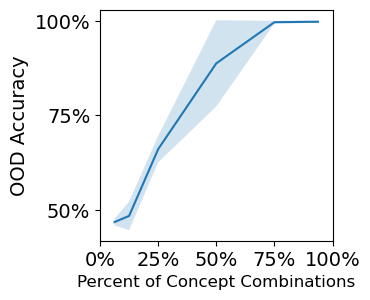

In [71]:
results = glob.glob("../../results/correlation/*.json")
all_json = [json.load(open(i)) for i in results]
keys = sorted(list(set([i['parameters']['num_concept_combinations'] for i in all_json])))
all_std = [np.std([i['out_distro'] for i in all_json if i['parameters']['num_concept_combinations'] == key]) for key in keys]
all_json = [np.mean([i['out_distro'] for i in all_json if i['parameters']['num_concept_combinations'] == key]) for key in keys]

all_json = np.array(all_json)
all_std = np.array(all_std)

plt.figure(figsize=(3,3))
plt.plot([key/16 for key in keys],all_json)
plt.yticks([0.5,0.75,1],["50%","75%","100%"],fontsize=14)
plt.xticks([0,0.25,0.5,0.75,1],["0%","25%","50%","75%","100%"],fontsize=14)
plt.xlim([0,1])
plt.ylabel("OOD Accuracy",fontsize=14)
plt.fill_between([key/16 for key in keys], all_json - all_std, all_json + all_std, alpha=0.2)

plt.xlabel("Percent of Concept Combinations",fontsize=12)
plt.savefig("../../results/figure",dpi=300, bbox_inches='tight')


In [ ]:
results = glob.glob("../../results/correlation/*.json")
all_json = [json.load(open(i)) for i in results]
keys = sorted(list(set([i['parameters']['num_concept_combinations'] for i in all_json])))
all_json = [np.mean([min(i['concept_accuracies']) for i in all_json if i['parameters']['num_concept_combinations'] == key]) for key in keys]

plt.figure(figsize=(3,3))
plt.plot([key/16 for key in keys],all_json)
plt.yticks([0,0.25,0.5,0.75,1],["0%","25%","50%","75%","100%"],fontsize=14)
plt.xticks([0,0.25,0.5,0.75,1],["0%","25%","50%","75%","100%"],fontsize=14)
plt.ylabel("Worst Concept Accuracy",fontsize=12)
plt.xlabel("Percent of Concept Combinations",fontsize=12)
plt.savefig("../../results/figures/correlations_flipped.pdf",dpi=300, bbox_inches='tight')


## CUB

In [48]:
def get_avg(results_by_part_mask):
    vals = []
    for i in results_by_part_mask:
        for j in results_by_part_mask[i]:
            if i!=j:
                vals.append(results_by_part_mask[i][j][0])
    return np.mean(vals) 

In [49]:
def get_avg_part_part(results_by_part_mask):
    vals = []
    for i in results_by_part_mask:
        for j in results_by_part_mask[i]:
            if i==j:
                vals.append(results_by_part_mask[i][j][0])
    return np.mean(vals) 

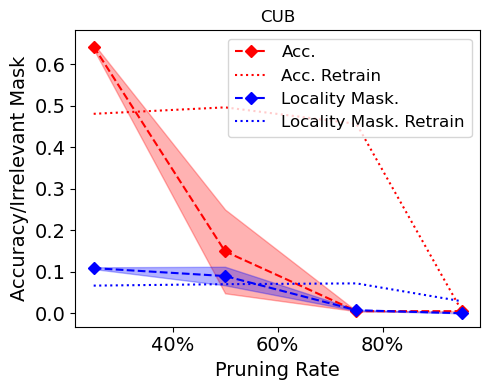

In [65]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

accuracy_values_retrain = []
leakage_values_retrain = []


for pruning_rate in [0.25,0.5,0.75,0.95]:
    accuracy_values.append([])
    leakage_values.append([])

    accuracy_values_retrain.append([])
    leakage_values_retrain.append([])

    for seed in seeds:
        for retrain_epochs in [0,5]:
            result_name = get_name_matching_parameters({'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/cub_pruning")
            result_name = result_name[-1]
            results_loc = '../../results/cub_pruning/{}.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))

            if retrain_epochs == 0:
                accuracy_values[-1].append(results['test_accuracy'])
                leakage_values[-1].append(get_avg(results['results_by_part_mask']))
            else:
                accuracy_values_retrain[-1].append(results['test_accuracy'])
                leakage_values_retrain[-1].append(get_avg(results['results_by_part_mask']))


accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T
accuracy_values_retrain = np.array(accuracy_values_retrain).T
leakage_values_retrain = np.array(leakage_values_retrain).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)
mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)
mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

x_vals = [0.25,0.5,0.75,0.95]

plt.figure(figsize=(5,4))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
plt.plot(x_vals, mean_accuracy, 'rD--', label="Acc.")
plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Acc. Retrain")

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
plt.plot(x_vals, mean_leakage, 'bD--', label="Locality Mask.")
plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Locality Mask. Retrain")

# Add labels, legend, and title
plt.title("CUB")

plt.xlabel('Pruning Rate',fontsize=14)
plt.ylabel('Accuracy/Irrelevant Mask',fontsize=14)
plt.xticks([0.4,0.6,0.8],["40%","60%","80%"],fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12,loc='upper right') 
plt.tight_layout()

plt.savefig("../../results/figures/pruning_cub.pdf",dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

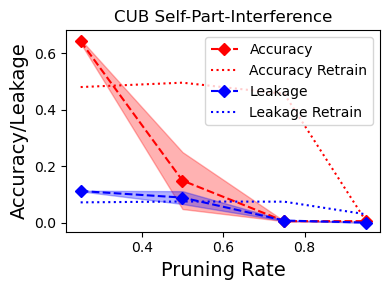

In [38]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

accuracy_values_retrain = []
leakage_values_retrain = []


for pruning_rate in [0.25,0.5,0.75,0.95]:
    accuracy_values.append([])
    leakage_values.append([])

    accuracy_values_retrain.append([])
    leakage_values_retrain.append([])

    for seed in seeds:
        for retrain_epochs in [0,5]:
            result_name = get_name_matching_parameters({'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/cub_pruning")
            result_name = result_name[-1]
            results_loc = '../../results/cub_pruning/{}.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))

            if retrain_epochs == 0:
                accuracy_values[-1].append(results['test_accuracy'])
                leakage_values[-1].append(get_avg_part_part(results['results_by_part_mask']))
            else:
                accuracy_values_retrain[-1].append(results['test_accuracy'])
                leakage_values_retrain[-1].append(get_avg_part_part(results['results_by_part_mask']))


accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T
accuracy_values_retrain = np.array(accuracy_values_retrain).T
leakage_values_retrain = np.array(leakage_values_retrain).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)
mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)
mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

x_vals = [0.25,0.5,0.75,0.95]

plt.figure(figsize=(4,3))

plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

plt.title("CUB Self-Part-Interference")
# Add labels, legend, and title
plt.xlabel('Pruning Rate',fontsize=14)
plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.legend() 
plt.tight_layout()

# Show the plot
plt.show()

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7


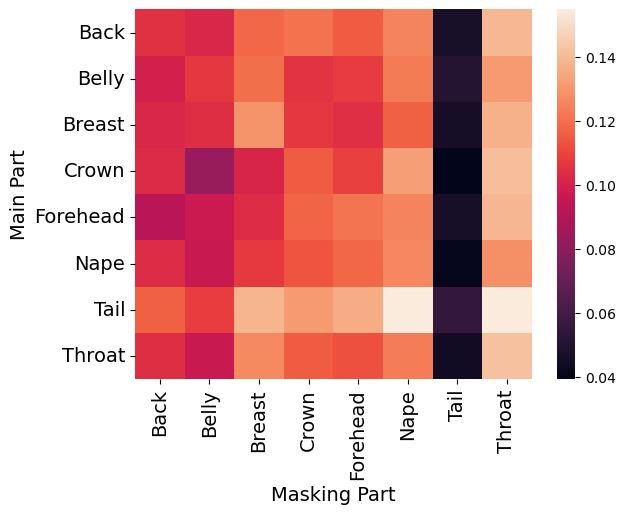

In [41]:
seeds = [42,43,44]

seed = 42
result_name = "../../results/cub/mask_epsilon_{}.json".format(seed)
results = json.load(open(result_name))
part_names = sorted(list(results['part_mask'].keys()))
inference_by_part = np.zeros((len(part_names),len(part_names)))
for seed in [42,43,44]:
    result_name = "../../results/cub/mask_epsilon_{}.json".format(seed)
    results = json.load(open(result_name))
    part_names_2 = sorted(results['part_mask'].keys())

    for i,p_1 in enumerate(part_names):
        for j,p_2 in enumerate(part_names):
            if p_2 in results['part_mask'][p_1]:
                print(i,j)
                inference_by_part[i,j] += results['part_mask'][p_1][p_2][0] 

inference_by_part /= len(seeds)
part_names_nice = [i.capitalize() for i in part_names]
sns.heatmap(inference_by_part,xticklabels=part_names_nice,yticklabels=part_names_nice)
plt.xlabel("Masking Part",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Main Part",fontsize=14)
plt.savefig("../../results/figures/cub_heatmap.pdf",dpi=300, bbox_inches='tight')


0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7


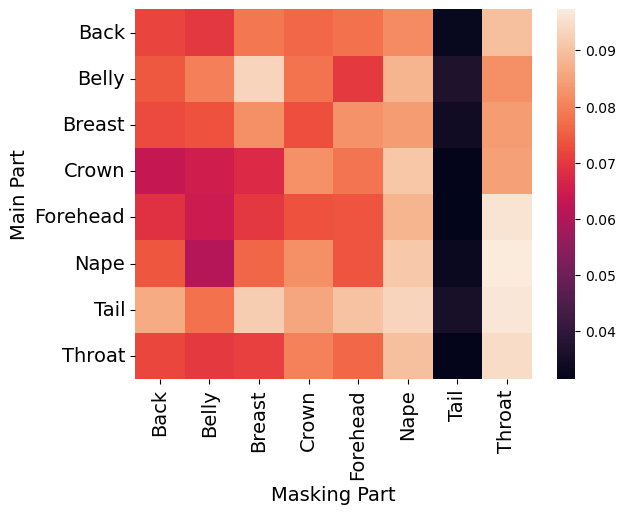

In [42]:
seeds = [42,43,44]

seed = 42
result_name = "../../results/cub/mask_epsilon_mean_color_{}.json".format(seed)
results = json.load(open(result_name))
part_names = sorted(list(results['part_mask'].keys()))
inference_by_part = np.zeros((len(part_names),len(part_names)))
for seed in [42,43,44]:
    result_name = "../../results/cub/mask_epsilon_mean_color_{}.json".format(seed)
    results = json.load(open(result_name))
    part_names_2 = sorted(results['part_mask'].keys())

    for i,p_1 in enumerate(part_names):
        for j,p_2 in enumerate(part_names):
            if p_2 in results['part_mask'][p_1]:
                print(i,j)
                inference_by_part[i,j] += results['part_mask'][p_1][p_2][0] 

inference_by_part /= len(seeds)
part_names_nice = [i.capitalize() for i in part_names]
sns.heatmap(inference_by_part,xticklabels=part_names_nice,yticklabels=part_names_nice)
plt.xlabel("Masking Part",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Main Part",fontsize=14)
plt.savefig("../../results/figures/cub_mean_heatmap.pdf",dpi=300, bbox_inches='tight')


#### Train Variations CUB

In [14]:
seeds = [42,43,44]

variation_list = ["none","loss","half"]
nice_name = ["Baseline","Half","Loss"]

accuracy_variation = []
leakage_variation = []

for seed in seeds:
    accuracy_variation.append([])
    leakage_variation.append([])

    for variation in variation_list:
        if variation != "none":
            results_loc = '../../results/cub/mask_epsilon_{}_{}.json'.format(variation,seed)
        else:
            results_loc = '../../results/cub/mask_epsilon_{}.json'.format(seed)
        results = json.load(open(results_loc,"r"))

        accuracy_variation[-1].append(results['test_acc'])
        leakage_variation[-1].append(get_avg_part_part(results['part_mask']))
    
accuracy_variation = np.array(accuracy_variation)
leakage_variation = np.array(leakage_variation)

mean_accuracy = np.mean(accuracy_variation,axis=0)
std_accuracy = np.std(accuracy_variation,axis=0)

mean_leakage = np.mean(leakage_variation,axis=0)
std_leakage = np.std(leakage_variation,axis=0)

plt.figure(figsize=(4,3))

fig, ax = plt.subplots(figsize=(6,4))

# Set the x-ticks and labels
ind = np.arange(2)
ax.set_xticks(ind)
ax.set_xticklabels(["Accuracy","Leakage"],fontsize=16)
ax.set_yticklabels(["0%","50%","100%"],fontsize=16)
ax.set_yticks([0,0.5,1])
ax.set_ylim([0,1])

# Set the y-axis label
ax.set_ylabel('Accuracy/Leakage',fontsize=20)
plt.xlabel("Metric",fontsize=20)

# Plot the bars with standard deviation error bars
width = 0.2
for i in range(len(mean_accuracy)):
    ax.bar(ind + (i-1)*width, [mean_accuracy[i],mean_leakage[i]], width, label=nice_name[i])


# plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
# plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
# plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

# plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
# plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
# plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

plt.title("CUB Training Variations",fontsize=24)
# # Add labels, legend, and title
# plt.xlabel('Pruning Rate',fontsize=14)
# plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.legend() 
plt.tight_layout()

plt.savefig("../../results/figures/train_variation_cub.pdf",dpi=300,bbox_inches='tight')

# Show the plot
plt.show()


NameError: name 'get_avg_part_part' is not defined

In [ ]:
accuracy_variation

### CUB Masks

In [ ]:
Image.open("../../results/cub/mask_creation/example_0.05_44.png")

In [ ]:
Image.open("../../results/cub/mask_creation/example_0.15_44.png")

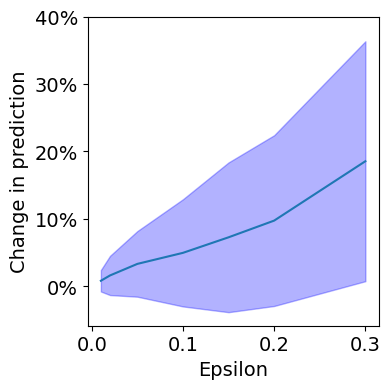

In [35]:
plt.figure(figsize=(4,4))
mask_results = [json.load(open("../../results/cub/mask_creation/mask_{}.json".format(seed))) for seed in [42,43,44]]
value_by_epsilon = []
std_by_epsilon = []
epsilon_values = sorted([float(i) for i in mask_results[0]['diff_by_epsilon'].keys()])

for ep in epsilon_values:
    value_by_epsilon.append(np.mean([i['diff_by_epsilon'][str(ep)][0] for i in mask_results]))
    std_by_epsilon.append(np.mean([i['diff_by_epsilon'][str(ep)][1] for i in mask_results]))
value_by_epsilon = np.array(value_by_epsilon)
std_by_epsilon = np.array(std_by_epsilon)
plt.plot(epsilon_values,value_by_epsilon)
plt.fill_between(epsilon_values, value_by_epsilon - std_by_epsilon, value_by_epsilon + std_by_epsilon, alpha=0.3, color='blue')
plt.xticks([0,0.1,0.2,0.3],fontsize=14)
plt.xlabel("Epsilon",fontsize=14)
plt.yticks([0,0.1,0.2,0.3,0.4],["0%","10%","20%","30%","40%"],fontsize=14)
plt.ylabel("Change in prediction",fontsize=14)
plt.tight_layout()
plt.savefig("../../results/figures/masking_cub.pdf",dpi=300,bbox_inches='tight')

## Coco

In [ ]:
def get_avg(results_by_part_mask):
    vals = []
    for i in results_by_part_mask:
        for j in results_by_part_mask[i]:
            if i!=j:
                vals.append(results_by_part_mask[i][j][0])
    return np.mean(vals) 

In [ ]:
def get_avg_part_part(results_by_part_mask):
    vals = []
    for i in results_by_part_mask:
        for j in results_by_part_mask[i]:
            if i==j:
                vals.append(results_by_part_mask[i][j][0])
    return np.mean(vals) 

In [ ]:
seeds = [42,43,44]

seed = 42
result_name = "../../results/coco/mask_none_{}.json".format(seed)
results = json.load(open(result_name))
part_names = sorted(results['part_mask'].keys())
train_locations = json.load(open(dataset_directory+"/coco/preprocessed/instances_train2014.json"))['categories']
concept_names = [[j['name'] for j in train_locations if j['id'] == int(i) ][0] for i in part_names]
inference_by_part = np.zeros((len(part_names),len(part_names)))

for seed in [42,43,44]:
    result_name = "../../results/coco/mask_none_{}.json".format(seed)
    results = json.load(open(result_name))
    part_names = sorted(results['part_mask'].keys())

    for i,p_1 in enumerate(part_names):
        for j,p_2 in enumerate(part_names):
            if p_2 in results['part_mask'][p_1]:
                inference_by_part[i,j] += results['part_mask'][p_1][p_2][0] 

inference_by_part /= len(seeds)
part_names_nice = [i.capitalize() for i in concept_names]
sns.heatmap(inference_by_part,xticklabels=part_names_nice,yticklabels=part_names_nice)
plt.xlabel("Masking Part",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Main Part",fontsize=14)

In [ ]:
seeds = [42,43,44]

variation_list = ["none","half","loss"]
nice_name = ["Baseline","Half","Loss"]
accuracy_variation = []
leakage_variation = []

for seed in seeds:
    accuracy_variation.append([])
    leakage_variation.append([])
    for variation in variation_list:
        results_loc = '../../results/coco/mask_{}_{}.json'.format(variation,seed)
        results = json.load(open(results_loc,"r"))

        accuracy_variation[-1].append(results['test_acc'])
        leakage_variation[-1].append(get_avg_part_part(results['part_mask']))


accuracy_variation = np.array(accuracy_variation).T
leakage_variation = np.array(leakage_variation).T

mean_accuracy = np.mean(accuracy_variation,axis=0)
std_accuracy = np.std(accuracy_variation,axis=0)

mean_leakage = np.mean(leakage_variation,axis=0)
std_leakage = np.std(leakage_variation,axis=0)

plt.figure(figsize=(4,3))

fig, ax = plt.subplots(figsize=(6,4))

# Set the x-ticks and labels
ind = np.arange(2)
ax.set_xticks(ind)
ax.set_xticklabels(["Accuracy","Leakage"],fontsize=16)
ax.set_yticklabels(["0%","50%","100%"],fontsize=16)
ax.set_yticks([0,0.5,1])
ax.set_ylim([0,1])

# Set the y-axis label
ax.set_ylabel('Accuracy/Leakage',fontsize=20)
plt.xlabel("Metric",fontsize=20)

# Plot the bars with standard deviation error bars
width = 0.2
for i in range(len(mean_accuracy)):
    ax.bar(ind + (i-1)*width, [mean_accuracy[i],mean_leakage[i]], width, label=nice_name[i])


# plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
# plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
# plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

# plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
# plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
# plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

plt.title("Coco Training Variations",fontsize=24)
# # Add labels, legend, and title
# plt.xlabel('Pruning Rate',fontsize=14)
# plt.ylabel('Accuracy/Leakage',fontsize=14)
plt.legend() 
plt.tight_layout()

plt.savefig("../../results/figures/train_variation_coco.pdf",dpi=300,bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
seeds = [42,43,44]

datasets = ["cub","coco"]
nice_name = ["CUB","Coco"]
accuracy_variation = []
leakage_variation = []

for seed in seeds:
    accuracy_variation.append([])
    leakage_variation.append([])
    for dataset in datasets:
        if dataset == "cub":
            results_loc = '../../results/cub/mask_epsilon_{}.json'.format(seed)
        elif dataset == "coco":
            results_loc = '../../results/coco/mask_none_{}.json'.format(seed)
        results = json.load(open(results_loc,"r"))

        accuracy_variation[-1].append(results['test_acc'])
        leakage_variation[-1].append(get_avg_part_part(results['part_mask']))


accuracy_variation = np.array(accuracy_variation)
leakage_variation = np.array(leakage_variation)

mean_accuracy = np.mean(accuracy_variation,axis=0)
std_accuracy = np.std(accuracy_variation,axis=0)

mean_leakage = np.mean(leakage_variation,axis=0)
std_leakage = np.std(leakage_variation,axis=0)

plt.figure(figsize=(4,3))

fig, ax = plt.subplots(figsize=(6,4))

# Set the x-ticks and labels
ind = np.arange(2)
ax.set_xticks(ind)
ax.set_xticklabels(["Accuracy","Leakage"],fontsize=16)
ax.set_yticklabels(["0%","50%","100%"],fontsize=16)
ax.set_yticks([0,0.5,1])
ax.set_ylim([0,1])

# Set the y-axis label
ax.set_ylabel('Accuracy/Leakage',fontsize=20)
plt.xlabel("Metric",fontsize=20)

# Plot the bars with standard deviation error bars
width = 0.2
for i in range(len(mean_accuracy)):
    ax.bar(ind + (i-1)*width, [mean_accuracy[i],mean_leakage[i]], width, label=nice_name[i])



plt.title("Masking Leakage, CUB and Coco",fontsize=20)
plt.legend() 
plt.tight_layout()

plt.savefig("../../results/figures/coco_cub_leakage.pdf",dpi=300,bbox_inches='tight')

# Show the plot
plt.show()

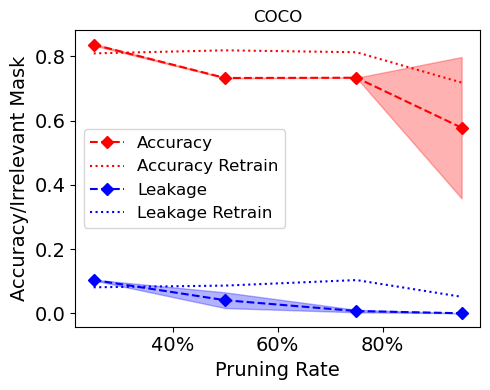

In [66]:
seeds = [42,43,44]

accuracy_values = []
leakage_values = []

accuracy_values_retrain = []
leakage_values_retrain = []


for pruning_rate in [0.25,0.5,0.75,0.95]:
    accuracy_values.append([])
    leakage_values.append([])

    accuracy_values_retrain.append([])
    leakage_values_retrain.append([])

    for seed in seeds:
        for retrain_epochs in [0,5]:
            result_name = get_name_matching_parameters({'seed': seed, 'prune_rate': pruning_rate, 'retrain_epochs': retrain_epochs},folder_name="results/coco_pruning")
            result_name = result_name[-1]
            results_loc = '../../results/coco_pruning/{}.json'.format(result_name,seed)
            results = json.load(open(results_loc,"r"))

            if retrain_epochs == 0:
                accuracy_values[-1].append(results['test_accuracy'])
                leakage_values[-1].append(get_avg(results['results_by_part_mask']))
            else:
                accuracy_values_retrain[-1].append(results['test_accuracy'])
                leakage_values_retrain[-1].append(get_avg(results['results_by_part_mask']))


accuracy_values = np.array(accuracy_values).T
leakage_values = np.array(leakage_values).T
accuracy_values_retrain = np.array(accuracy_values_retrain).T
leakage_values_retrain = np.array(leakage_values_retrain).T

mean_accuracy = np.mean(accuracy_values,axis=0)
std_accuracy = np.std(accuracy_values,axis=0)
mean_accuracy_retrain = np.mean(accuracy_values_retrain,axis=0)
std_accuracy_retrain = np.std(accuracy_values_retrain,axis=0)

mean_leakage = np.mean(leakage_values,axis=0)
std_leakage = np.std(leakage_values,axis=0)
mean_leakage_retrain = np.mean(leakage_values_retrain,axis=0)
std_leakage_retrain = np.std(leakage_values_retrain,axis=0)

x_vals = [0.25,0.5,0.75,0.95]

plt.figure(figsize=(5,4))
plt.title("COCO")


plt.fill_between(x_vals, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, alpha=0.3, color='red')
plt.plot(x_vals, mean_accuracy, 'rD--', label="Accuracy")
plt.plot(x_vals, mean_accuracy_retrain, 'r:', label="Accuracy Retrain")

plt.fill_between(x_vals, mean_leakage - std_leakage, mean_leakage + std_leakage, alpha=0.3, color='blue')
plt.plot(x_vals, mean_leakage, 'bD--', label="Leakage")
plt.plot(x_vals, mean_leakage_retrain, 'b:', label="Leakage Retrain")

# Add labels, legend, and title
plt.xlabel('Pruning Rate',fontsize=14)
plt.ylabel('Accuracy/Irrelevant Mask',fontsize=14)
plt.xticks([0.4,0.6,0.8],["40%","60%","80%"],fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12,loc='center left') 
plt.tight_layout()

plt.savefig("../../results/figures/pruning_coco.pdf",dpi=300, bbox_inches='tight')


# Show the plot
plt.show()

## DSprites 

In [ ]:
sns.reset_orig()
all_our_distance = []
all_ground_truth = []

concept_names = [
    "is_white",
    "is_square",
    "is_ellipse",
    "is_heart",
    "is_scale_0.5",
    "is_scale_0.6",
    "is_scale_0.7",
    "is_scale_0.8",
    "is_scale_0.9",
    "is_scale_1",
    "is_orientation_0",
    "is_orientation_90",
    "is_orientation_180",
    "is_orientation_270",
    "is_x_0",
    "is_x_16",
    "is_y_0",
    "is_y_16",
] 

for seed in [42,43,44]:
    predictions = json.load(open('results/dsprites/dsprites_20_predictions_{}.json'.format(seed),'r'))
    all_predictions = predictions['our_predictions']
    present_concept_combo = predictions['train_concepts']
    correct_answers = predictions['ground_truths']
    extra_predictions = predictions['predictions_raw']

    our_distance_freq = []
    ground_truth_distance_freq = []


    for i,pred in enumerate(all_predictions):
        distances = [hamming_distance(all_predictions[i],j) for j in present_concept_combo]
        min_distance = np.min(distances)
        our_distance_freq.append(min_distance)

    for i,pred in enumerate(correct_answers):
        distances = [hamming_distance(correct_answers[i],j) for j in present_concept_combo]
        min_distance = np.min(distances)
        ground_truth_distance_freq.append(min_distance)
    ground_truth_distance_freq = Counter(ground_truth_distance_freq)
    our_distance_freq = Counter(our_distance_freq)

    for i in our_distance_freq:
        if i not in ground_truth_distance_freq:
            ground_truth_distance_freq[i] = 0

    all_our_distance.append([our_distance_freq[i] for i in range(5)])
    all_ground_truth.append([ground_truth_distance_freq[i] for i in range(5)])

all_our_distance = np.array(all_our_distance)
all_ground_truth = np.array(all_ground_truth)

labels = [0, 1, 2, 3, 4]

# Set the width of the bars
bar_width = 0.35

# Calculate the x-coordinates for the bars
x = np.arange(len(labels))

# Create a figure and axis for the bar graph
fig, ax = plt.subplots(figsize=(5,5))

ground_truth_mean = np.mean(all_ground_truth,axis=0)
ground_truth_std = np.std(all_ground_truth,axis=0)

our_distance_mean =  np.mean(all_our_distance,axis=0)
our_distance_std = np.std(all_our_distance,axis=0)

# Create blue bars for ground_truth_distance_freq (or 0 if not present)
ax.bar(x - bar_width/2, ground_truth_mean, bar_width, yerr=ground_truth_std, color='blue', label='Ground Truth Label')

# Create yellow bars for our_distance_freq (or 0 if not present)
ax.bar(x + bar_width/2, our_distance_mean, bar_width, yerr=our_distance_std,color='red', label='Predicted Label', alpha=0.7)

# Set labels and title
ax.set_xlabel('Hamming Distance from Closest Training Point',fontsize=14)
ax.set_ylabel('Frequency',fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(labels,fontsize=14)
ax.set_yticks([0,50,100,150])
ax.set_yticklabels([0,50,100,150],fontsize=14)
ax.legend(fontsize='14')

# Show the plot
plt.tight_layout()
plt.savefig("results/figures/dsprites_distance_bar.pdf",dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pca_dict = json.load(open('results/dsprites/pca_images.json','r'))
pca_images = np.array(pca_dict['pca_images'])
image_similarities = np.array(pca_dict['image_similarities'])
svm_accuracies = np.array(pca_dict['svm_accuracies'])

predictions = json.load(open('results/dsprites/dsprites_20_predictions.json','r'))
all_predictions = predictions['our_predictions']
present_concept_combo = predictions['train_concepts']
correct_answers = predictions['ground_truths']
attributes_as_matrix = np.array([[int(j) for j in i] for i in correct_answers])


for attribute in ['is_x_16','is_heart']:
    i = concept_names.index(attribute)
    first_attribute = attributes_as_matrix[:, i]

    attribute_to_title = {
        'is_x_16': 'Object Right Half',
        'is_heart': 'Heart Shaped'
    }

    # Create a scatter plot and color by the first attribute
    plt.figure(figsize=(5,3))
    plt.scatter(pca_images[:, 0], pca_images[:, 1], c=first_attribute, cmap='viridis')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(attribute_to_title[attribute])
    plt.colorbar(label='Concept Label')
    plt.tight_layout() 

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig("results/figures/{}_pca.pdf".format(attribute),dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure()


In [ ]:
results = json.load(open('results/dsprites/dsprites_20_results_42.json'))
pca_dict = json.load(open('results/dsprites/pca_images.json','r'))
svm_accuracies = np.array(pca_dict['svm_accuracies'])


X = svm_accuracies
y = [1-results[i]['freq_with_concept_adversarial'][0]/results[i]['freq_with_concept_adversarial'][1] for i in concept_names]

plt.figure(figsize=(3,3))
plt.xlabel("Concept Accuracy",fontsize=14)
plt.ylabel("Generalization Accuracy",fontsize=14)
xtick_labels = ['60%', '80%','100%']
plt.xticks([0.6,0.8,1], xtick_labels,fontsize=12)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],['0%','20%','40%','60%','80%','100%'],fontsize=12)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.scatter(x=X,y=y)
plt.savefig("results/figures/adversarial_scatter.pdf",dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
min(y)

## CUB

In [ ]:
targeted_mask_list = [json.load(open("results/cub/mask_epsilon_{}.json".format(seed),"r")) for seed in [42,43,44]]
random_mask_list = [json.load(open("results/cub/mask_random_{}.json".format(seed),"r")) for seed in [42,43,44]]
closest_mask_list = [json.load(open("results/cub/mask_closest_{}.json".format(seed),"r")) for seed in [42,43,44]]

target_y = [[] for i in range(5)]
random_y = [[] for i in range(5)]
closest_y = [[] for i in range(5)]
for part in targeted_mask_list[0]['mean']:
    for i,epsilon in enumerate(targeted_mask_list[0]['mean'][part]):
        for seed_num in range(3):
            target_val = round(targeted_mask_list[seed_num]['mean'][part][epsilon],2)
            random_val = round(random_mask_list[seed_num]['mean'][part][epsilon],2)
            closest_val = round(closest_mask_list[seed_num]['mean'][part][epsilon],2)

            target_y[i].append(target_val)
            random_y[i].append(random_val) 
            closest_y[i].append(closest_val)

x_values = list(range(len(target_y)))

# Calculate means and standard deviations
target_mean = np.mean(target_y, axis=1)
random_mean = np.mean(random_y, axis=1)
closest_mean = np.mean(closest_y, axis=1)

target_std = np.std(target_y, axis=1)
random_std = np.std(random_y, axis=1)
closest_std = np.std(closest_y, axis=1)

# Create the plot
# sns.set(style="whitegrid")
plt.figure(figsize=(5,3))

plt.yticks([0,0.2,0.4,0.6,0.8],["0%","20%","40%","60%","80%"],fontsize=14)
plt.xticks([0,1,2,3,4],["10","20","30","40","50"],fontsize=14)
plt.xlabel("Epsilon ($\epsilon$)",fontsize=14)
plt.ylabel("Concept Pred. Diff.",fontsize=14)


# Line plots with standard deviations and custom labels
plt.plot(x_values, target_mean, label='Full', color='blue')
plt.fill_between(x_values, target_mean - target_std, target_mean + target_std, color='blue', alpha=0.2)

plt.plot(x_values, random_mean, label='Random', color='orange')
plt.fill_between(x_values, random_mean - random_std, random_mean + random_std, color='orange', alpha=0.2)

plt.plot(x_values, closest_mean, label='Closest', color='green')
plt.fill_between(x_values, closest_mean - closest_std, closest_mean + closest_std, color='green', alpha=0.2)
plt.legend(fontsize="14")
plt.savefig("results/figures/cub_epsilon.pdf",dpi=300, bbox_inches='tight')
plt.show()

# Other Plots

## Synthetic Dataset Exploration

In [ ]:
for num_objects in [1,2,4]:
    file_loc = "results/synthetic/objects={}_noisy=False_wd=0.0004_model=small3_optimizer=sgd_seed=42/1.png".format(
        num_objects)
    img = Image.open(file_loc)
    plt.imshow(img)
    plt.figure()

In [ ]:
file_loc = "results/synthetic/objects=2_noisy=True_wd=0.0004_model=inceptionv3_optimizer=sgd_seed=42/1.png"
img = Image.open(file_loc)
plt.imshow(img)
plt.figure()

## Impact of Various Factors

### Impact of Model Size + Dataset Size

In [ ]:
for model_size in range(3,8):
    model_name = 'small{}'.format(model_size)
    file_loc = "results/synthetic/objects=1_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json".format(
        model_name)
    results = json.loads(open(file_loc,"r").read())
    print(model_size,results['adversarial_activations'])

In [ ]:
for model_size in [3,5,7]:
    model_name = 'small{}'.format(model_size)
    file_loc = "results/synthetic/objects=2_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json".format(
        model_name)
    results = json.loads(open(file_loc,"r").read())
    print(model_size,results['adversarial_activations'])

In [ ]:
for model_size in [3,5,7]:
    model_name = 'small{}'.format(model_size)
    file_loc = "results/synthetic/objects=4_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json".format(
        model_name)
    results = json.loads(open(file_loc,"r").read())
    print(model_size,results['adversarial_activations'])

In [ ]:
for method_name in ['gradcam','integrated_gradients','saliency']:
    img_loc = 'results/synthetic/objects=2_noisy=False_wd=0.0004_model=small3_optimizer=sgd_seed=42/{}.png'.format(method_name)
    img = mpimg.imread(img_loc)
    plt.imshow(img)
    plt.figure()

In [ ]:
for method_name in ['gradcam','integrated_gradients','saliency']:
    img_loc = 'results/synthetic/objects=2_noisy=False_wd=0.0004_model=small5_optimizer=sgd_seed=42/{}.png'.format(method_name)
    img = mpimg.imread(img_loc)
    plt.imshow(img)
    plt.figure()

In [ ]:
for method_name in ['gradcam','integrated_gradients','saliency']:
    img_loc = 'results/synthetic/objects=2_noisy=False_wd=0.0004_model=small7_optimizer=sgd_seed=42/{}.png'.format(method_name)
    img = mpimg.imread(img_loc)
    plt.imshow(img)
    plt.figure()

## MLP Models

In [ ]:
for model_size in [0,2,5,10,15,20,25]:
    model_name = "mlp_{}".format(model_size)
    results_loc = 'results/synthetic/objects=1_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json'.format(model_name)
    results = json.load(open(results_loc,"r"))

    print("For model {}, activations {}, accuracy {}".format(model_name,results['adversarial_activations'],results['concept_accuracy']))

In [ ]:
results_loc = 'results/synthetic/objects=1_noisy=False_wd=0.0004_model=mlp_0_0_optimizer=sgd_seed=42/results.json'
results = json.load(open(results_loc,"r"))

print("For flat model, activations {}, accuracy {}".format(results['adversarial_activations'],results['concept_accuracy']))

In [ ]:
for model_size in [2,5,10,15,20,25]:
    model_name = "mlp_{}_1".format(model_size)
    results_loc = 'results/synthetic/objects=1_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json'.format(model_name)
    results = json.load(open(results_loc,"r"))

    print("For model {}, activations {}, accuracy {}".format(model_name,results['adversarial_activations'],results['concept_accuracy']))

In [ ]:
for model_size in [5,10,15]:
    model_name = "mlp_{}_2".format(model_size)
    results_loc = 'results/synthetic/objects=1_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json'.format(model_name)
    results = json.load(open(results_loc,"r"))

    print("For model {}, activations {}, accuracy {}".format(model_name,results['adversarial_activations'],results['concept_accuracy']))

In [ ]:
for model_size in [5,10,15]:
    model_name = "mlp_{}_3".format(model_size)
    results_loc = 'results/synthetic/objects=1_noisy=False_wd=0.0004_model={}_optimizer=sgd_seed=42/results.json'.format(model_name)
    results = json.load(open(results_loc,"r"))

    print("For model {}, activations {}, accuracy {}".format(model_name,results['adversarial_activations'],results['concept_accuracy']))

### Impact of Optimizer (SAM)

In [ ]:
for method_name in ['gradcam','integrated_gradients','saliency']:
    img_loc = 'results/synthetic/objects=4_noisy=False_wd=0.0004_model=small7_optimizer=sam_seed=42/{}.png'.format(method_name)
    img = mpimg.imread(img_loc)
    plt.imshow(img)
    plt.figure()

In [ ]:
json_file = "results/synthetic/objects=4_noisy=False_wd=0.0004_model=small7_optimizer=sam_seed=42/results.json"
json_file = json.load(open(json_file))
json_file

### Impact of Noisy Dataset 

In [ ]:
for method_name in ['gradcam','integrated_gradients','saliency']:
    img_loc = 'results/synthetic/objects=2_noisy=True_wd=0.0004_model=inceptionv3_optimizer=sgd_seed=42/{}.png'.format(method_name)
    img = mpimg.imread(img_loc)
    plt.imshow(img)
    plt.figure()

In [ ]:
json_file = "results/synthetic/objects=2_noisy=True_wd=0.0004_model=inceptionv3_optimizer=sgd_seed=42/results.json"
json_file = json.load(open(json_file))
json_file

### Impact of SoftPlus

In [ ]:
for method_name in ['gradcam','integrated_gradients','saliency']:
    img_loc = 'results/synthetic/objects=1_noisy=False_wd=0.0004_model=small7_softplus_optimizer=sgd_seed=42/{}.png'.format(method_name)
    img = mpimg.imread(img_loc)
    plt.imshow(img)
    plt.figure()

## Explanation Qualities

### Quantiative Analysis

In [ ]:
seed = 42

explanation_metrics = {}

for i in [1,2,4]:
    explanation_i = json.load(open("results/explanations/objects={}_seed=42/evaluation.json".format(i)))
    for key in explanation_i:
        for sub_key in explanation_i[key]:
            explanation_i[key][sub_key] = (np.mean(explanation_i[key][sub_key]),np.std(explanation_i[key][sub_key]))
    explanation_metrics[i] = explanation_i 

In [ ]:
for num_objects in explanation_metrics:
    print("=={}==".format(num_objects))
    for key in explanation_metrics[num_objects]['distances']:
        avg_value = explanation_metrics[num_objects]['distances'][key][0]
        avg_value = round(avg_value,2)
        print("Distance between small and large model explanations {}: {}".format(key,avg_value))

In [ ]:
for num_objects in explanation_metrics:
    print("=={}==".format(num_objects))
    for key in explanation_metrics[num_objects]['small_intensities']:
        avg_value = explanation_metrics[num_objects]['small_intensities'][key][0]
        avg_value = round(avg_value,2)
        print("Left-side localization in small models {}: {}".format(key,avg_value))

In [ ]:
for num_objects in explanation_metrics:
    print("=={}==".format(num_objects))
    for key in explanation_metrics[num_objects]['large_intensities']:
        avg_value = explanation_metrics[num_objects]['large_intensities'][key][0]
        avg_value = round(avg_value,2)
        print("Left-side localization in large models {}: {}".format(key,avg_value))

### Qualitative Results

In [ ]:
num_objects = 2

In [ ]:
for method in ['saliency','integrated_gradients','gradcam']:
    file_loc = "results/synthetic/objects={}_noisy=False_wd=0.0004_model=small3_optimizer=sgd_seed=42/{}.png".format(
        num_objects,method)
    img = Image.open(file_loc)
    plt.imshow(img)
    plt.figure()


In [ ]:
for method in ['saliency','integrated_gradients','gradcam']:
    file_loc = "results/synthetic/objects={}_noisy=False_wd=0.0004_model=small5_optimizer=sgd_seed=42/{}.png".format(
        num_objects,method)
    img = Image.open(file_loc)
    plt.imshow(img)
    plt.figure()


In [ ]:
for method in ['saliency','integrated_gradients','gradcam']:
    file_loc = "results/synthetic/objects={}_noisy=False_wd=0.0004_model=small7_optimizer=sgd_seed=42/{}.png".format(
        num_objects,method)
    img = Image.open(file_loc)
    plt.imshow(img)
    plt.figure()


## CUB Masking

In [ ]:
sns.lineplot(target_y)
plt.xticks(list(range(len(target_y[0]))), list(targeted_mask[0]['mean'].keys()))

In [ ]:
dataset_name = "CUB"
data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)
train_data_path = os.path.join(data_dir, 'train.pkl')
train_pkl = pickle.load(open(train_data_path,"rb"))

In [ ]:
attribute_names = open("../cem/cem/CUB/metadata/attributes.txt").read().strip().split("\n")

In [ ]:
paired = []

for i in range(112):
    for j in range(i):
        for k in train_pkl:
            if k['attribute_label'][i] != k['attribute_label'][j]:
                break 
        else:
            paired.append((attribute_names[i],attribute_names[j]))
paired

## MLP Experiments

In [ ]:
mlp_results = json.load(open('results/synthetic/mlp_results.json','r'))

In [ ]:
img_loc = 'results/synthetic/mlp_adversarial_filter_1.png'
img = mpimg.imread(img_loc)
plt.imshow(img)

## Overall Adversarial Concept Exploration

In [ ]:
accuracies = json.load(open('results/dsprites/dsprites_20_accuracy.json','r'))

In [ ]:
predictions = json.load(open('results/dsprites/dsprites_20_predictions.json','r'))
all_predictions = predictions['our_predictions']
present_concept_combo = predictions['train_concepts']
correct_answers = predictions['ground_truths']
extra_predictions = predictions['predictions_raw']

In [ ]:
results = json.load(open('results/dsprites/dsprites_20_results_42.json'))
results_5 = json.load(open('results/dsprites/dsprites_5_results_42.json'))
results_10 = json.load(open('results/dsprites/dsprites_10_results_42.json'))
results_15 = json.load(open('results/dsprites/dsprites_15_results_42.json'))

In [ ]:
pca_dict = json.load(open('results/dsprites/pca_images.json','r'))
pca_images = np.array(pca_dict['pca_images'])
image_similarities = np.array(pca_dict['image_similarities'])
svm_accuracies = np.array(pca_dict['svm_accuracies'])

In [ ]:
summary_stats = json.load(open('results/dsprites/summary_stats.json','r'))

## Individual Concept Exploration

In [ ]:
concept_of_interest = 'is_heart'
concept_idx = concept_names.index(concept_of_interest)
argmin_with_concept = results[concept_of_interest]['argmin_with_concept']
argmax_with_concept = results[concept_of_interest]['argmax_with_concept']
combo_with_concept = [i for i in present_concept_combo if i[concept_idx] == '1']

In [ ]:
list_to_index = {}
for i in range(len(correct_answers)):
    list_to_index[list_to_string(correct_answers[i])] = i

In [ ]:
num_predicted_not_seen = len([i for i in all_predictions if i not in present_concept_combo])/len(all_predictions)

In [ ]:
num_predicted_not_subset = []

for i in all_predictions:
    for j in present_concept_combo: 
        for k in range(len(i)):
            if i[k] == '1' and j[k] == '0':
                break 
        else:
            num_predicted_not_subset.append(i)
num_predicted_not_subset = len(num_predicted_not_subset)/len(all_predictions)
num_predicted_not_subset

In [ ]:
all_with_1 = []
for i in list_to_index:
    if i[concept_idx] == '1':
        distances = [hamming_distance(i,j) for j in combo_with_concept]
        idx = np.argmin(distances)
        min_dist = distances[idx] 
        flipped_concepts = hamming_distance(i,combo_with_concept[idx],diff_names=concept_names,ret_diff=True)
        idx = list_to_index[i] 
        pred = extra_predictions[idx][concept_idx]
        all_with_1.append({'dist': min_dist, 'name': i, 'prediction': pred, 'differences': flipped_concepts[1]})
predictions = [i['prediction'] for i in all_with_1]

In [ ]:
list_flatten_1 = list(itertools.chain(*[i['differences'] for i in all_with_1 if i['prediction'] >= 0.75]))
list_flatten_0 = list(itertools.chain(*[i['differences'] for i in all_with_1 if i['prediction'] < 0.75]))

In [ ]:
counter_1 = Counter(list_flatten_1)
counter_0 = Counter(list_flatten_0) 

for i in counter_1:
    counter_1[i] /= len(list_flatten_1)
    counter_1[i] = round(counter_1[i],2)

    if i not in counter_0:
        counter_0[i] = 0.0

for i in counter_0:
    counter_0[i] /= len(list_flatten_0)
    counter_0[i] = round(counter_0[i],2)

    if i not in counter_1:
        counter_1[i] = 0.0

counter_0 = dict(counter_0)
counter_1 = dict(counter_1)

In [ ]:
keys = list(counter_1.keys())
values_1 = list(counter_1.values())
values_0 = list(counter_0.values())

width = 0.4  # Width of the bars
x = np.arange(len(keys))  # Numeric locations for the bars

plt.bar(x - width/2, values_1, width, color='blue', label='>= 0.75')
plt.bar(x + width/2, values_0, width, color='#FFFF99', label='< 0.75')  # Light yellow

plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Frequency for {}'.format(concept_of_interest))
plt.xticks(x, keys, rotation='vertical')  # Rotate x-axis labels vertically
plt.legend()
plt.tight_layout()  # Adjust layout for better appearance
plt.gcf().set_size_inches(10, 6)  # Adjust the width of the graph
plt.show()

In [ ]:
sns.set(style="whitegrid")  # Set the style of the plot
sns.kdeplot(predictions, shade=True)  # Create the kernel density plot
plt.xlabel("Value")  # Label for x-axis
plt.ylabel("Density")  # Label for y-axis
plt.title("Predictions for concept {}".format(concept_of_interest))  # Title of the plot
plt.show()  # Show the plot

In [ ]:
sns.reset_orig()

## Patterns in Concept Adversarialness

In [ ]:
accuracy_by_distance = {}

for i in range(len(correct_answers)):
    distances = [hamming_distance(correct_answers[i],j) for j in present_concept_combo]
    min_distance = np.min(distances)

    if min_distance not in accuracy_by_distance:
        accuracy_by_distance[min_distance] = []

    accuracy_by_distance[min_distance].append(int(all_predictions[i] == correct_answers[i]))

for i in accuracy_by_distance:
    accuracy_by_distance[i] = (np.mean(accuracy_by_distance[i]),len(accuracy_by_distance[i]))

In [ ]:
concept_accuracy_by_distance = {}
for i in range(len(correct_answers)):
    for concept_name in concept_names:
        concept_idx = concept_names.index(concept_name)
        if concept_name not in concept_accuracy_by_distance:
            concept_accuracy_by_distance[concept_name] = {}

        distances = [hamming_distance(correct_answers[i],j) for j in present_concept_combo]
        min_distance = np.min(distances)

        if min_distance not in concept_accuracy_by_distance[concept_name]:
            concept_accuracy_by_distance[concept_name][min_distance] = []

        concept_accuracy_by_distance[concept_name][min_distance].append(int(all_predictions[i][concept_idx] == correct_answers[i][concept_idx]))

for i in concept_accuracy_by_distance:
    for j in concept_accuracy_by_distance[i]:
        concept_accuracy_by_distance[i][j] = (np.mean(concept_accuracy_by_distance[i][j]),len(concept_accuracy_by_distance[i][j]))


In [ ]:
frequency_train_concept_distance = {}
for i,pred in enumerate(all_predictions):
    distances = [hamming_distance(all_predictions[i],j) for j in present_concept_combo]
    min_distance = np.min(distances)

    if min_distance not in frequency_train_concept_distance:
        frequency_train_concept_distance[min_distance] = []

    frequency_train_concept_distance[min_distance].append(int(pred in present_concept_combo))

for i in frequency_train_concept_distance:
    frequency_train_concept_distance[i] = (np.mean(frequency_train_concept_distance[i]),len(frequency_train_concept_distance[i]))

In [ ]:
frequency_train_concept_distance

In [ ]:
concept_pairs = [(1,2),(2,3),(1,3)] # Manually encode the same shape

for i,name in enumerate(concept_names):
    for j,name_2 in enumerate(concept_names):
        if name.split("_")[1] == name_2.split("_")[1] and name > name_2:
            concept_pairs.append((i,j))

In [ ]:
freq_double_pair = []
for i in all_predictions:
    has_pair = False

    for p_1,p_2 in concept_pairs:
        if i[p_1] == i[p_2] == '1':
            has_pair = True
            break
    
    freq_double_pair.append(int(has_pair))
freq_double_pair = np.mean(freq_double_pair)
freq_double_pair

In [ ]:
double_pairs = []
for i in all_predictions:
    has_pair = False

    for p_1,p_2 in concept_pairs:
        if i[p_1] == i[p_2] == '1':
            double_pairs.append((concept_names[p_1],concept_names[p_2]))
double_pairs = Counter(double_pairs)

In [ ]:
concept_sets = [
    ["is_square",
    "is_ellipse",
    "is_heart"],[
    "is_scale_0.5",
    "is_scale_0.6",
    "is_scale_0.7",
    "is_scale_0.8",
    "is_scale_0.9",
    "is_scale_1",],[
    "is_orientation_0",
    "is_orientation_90",
    "is_orientation_180",
    "is_orientation_270",],
    ["is_x_0",
    "is_x_16",],[
    "is_y_0",
    "is_y_16",]
] 

In [ ]:
freq_no_pair = []
for i in all_predictions:
    has_no_pair = False

    for s in concept_sets:
        for elem in s:
            if i[concept_names.index(elem)] == '1':
                break
        else:
            has_no_pair = True
    
    freq_no_pair.append(int(has_no_pair))
freq_no_pair = np.mean(freq_no_pair)
freq_no_pair

In [ ]:
freq_no_pair = []
for i in all_predictions:
    has_no_pair = False

    for s in concept_sets:
        for elem in s:
            if i[concept_names.index(elem)] == '1':
                break
        else:
            freq_no_pair.append(s[0])
Counter(freq_no_pair)

## Concept Difficulty

In [ ]:
closest_pair_same_concept = {}
furthest_pair_same_concept = {}
avg_dist_same_concept = {}

attributes_as_matrix = np.array([[int(j) for j in i] for i in correct_answers])

for i,concept in enumerate(concept_names):
    if i == 0:
        continue

    data_points_with_concept = np.where(attributes_as_matrix[:,i] == 1)[0]
    similarities_with_point = image_similarities[:,data_points_with_concept][data_points_with_concept]

    furthest_pair_same_concept[concept] = np.max(similarities_with_point).item()

    for j in range(len(similarities_with_point)):
        similarities_with_point[j][j] = 10000

    closest_pair_same_concept[concept] = np.min(similarities_with_point).item()
    avg_dist_same_concept[concept] = np.mean(similarities_with_point).item()
